# Problema de Fluxo Máximo (PFM)

O **Problema de Fluxo Máximo (PFM)** é um problema clássico da **Teoria dos Grafos** e da **Pesquisa Operacional**, cujo objetivo é determinar a maior quantidade possível de fluxo que pode ser enviada de uma **origem** para um **destino** em uma rede sujeita a restrições de capacidade nas conexões. Esse problema tem diversas aplicações em transporte, redes de comunicação, logística e sistemas de abastecimento.

In [48]:
import cplex
import networkx as nx
import matplotlib.pyplot as plt

## Leitura e pré-processamento dos dados

Dado um **grafo dirigido** $G = (V, E)$, onde:  
- $V$ é o conjunto de **nós (vértices)**, incluindo:  
  - $s$ (origem): Nó onde o fluxo é gerado.  
  - $t$ (destino): Nó onde o fluxo deve chegar.  
- $E$ é o conjunto de **arestas**, onde cada aresta $(i, j)$ tem:  
  - **Capacidade $c_{ij}$**: O máximo fluxo que pode passar por essa aresta.  
  - **Fluxo $x_{ij}$**: A quantidade de fluxo que efetivamente passa por essa aresta.

In [49]:
file = "in_pfm.txt"

with open(file, 'r') as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = list(filter(None, lines))

num_nodes, num_edges = map(int, lines[0].strip().split())
s, t = map(int, lines[1].strip().split())

arcs = {}
for line in lines[2:]:
    node1, node2, capacity = map(int, line.strip().split())
    arcs[(node1, node2)] = capacity

arcs

{(0, 1): 8,
 (0, 2): 18,
 (1, 4): 12,
 (1, 3): 4,
 (1, 2): 10,
 (2, 3): 5,
 (2, 5): 10,
 (3, 4): 7,
 (3, 5): 14,
 (4, 6): 20,
 (5, 6): 6}

## Visualização do problema

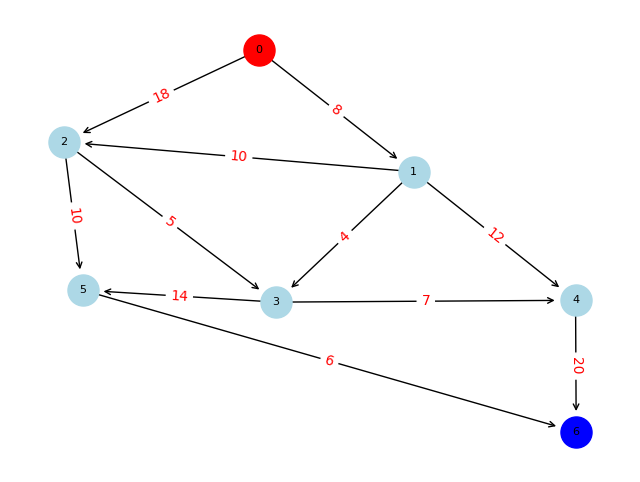

In [50]:
G = nx.DiGraph()

G.add_nodes_from(range(num_nodes))

for (u, v), cost in arcs.items():
    G.add_edge(u, v, weight=cost)

pos = nx.spring_layout(G, k=1.0, iterations=50)

path_nodes = [node for node in G.nodes() if node not in [s, t]]
node_labels = {i: f'{i}' for i in G.nodes}
edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, nodelist=[s], node_color='red', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=[t], node_color='blue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, min_target_margin = 15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.axis('off')
plt.show()

## Modelagem e solução

O objetivo é **maximizar o fluxo total** da origem $s$ até o destino $t$, respeitando as seguintes restrições:  

1. **Restrição de Capacidade**: O fluxo em uma aresta não pode ultrapassar sua capacidade:  
$0 \leq x_{ij} \leq c_{ij}, \quad \forall (i,j) \in E$

2. **Conservação de Fluxo**: Para todos os nós exceto a origem e o destino, o fluxo que entra deve ser igual ao fluxo que sai:  
$\sum_{j \in V} x_{ji} = \sum_{j \in V} x_{ij}, \quad \forall i \in V \setminus \{s, t\}$

3. **O Fluxo Total** que sai da origem deve ser maximizado:  
$\max \sum_{j \in V} x_{sj}$

In [51]:
model = cplex.Cplex()
model.set_problem_type(cplex.Cplex.problem_type.LP)
model.objective.set_sense(model.objective.sense.maximize)

# Adiciona variáveis de decisão para cada aresta com capacidade como limite superior
# Nota: o limite inferior é 0 por padrão
edge_names = []
for (i, j), capacity in arcs.items():
    var_name = f"x{i}{j}"
    model.variables.add(names=[var_name], lb=[0], ub=[capacity])
    edge_names.append(var_name)

# Adiciona restrições de conservação de fluxo para cada nó
for node in range(num_nodes):
    if node == s or node == t:
        continue
    inflow = [f"x{i}{node}" for i in range(num_nodes) if (i, node) in arcs]
    outflow = [f"x{node}{j}" for j in range(num_nodes) if (node, j) in arcs]
    model.linear_constraints.add(
        lin_expr=[cplex.SparsePair(inflow + outflow, [1] * len(inflow) + [-1] * len(outflow))],
        senses=["E"],
        rhs=[0]
    )

# Define a função objetivo para maximizar o fluxo de saída do nó de origem
outflow_source = [f"x{s}{j}" for j in range(num_nodes) if (s, j) in arcs]
model.objective.set_linear([(var, 1) for var in outflow_source])

%time model.solve()

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 1 rows and 3 columns.
Reduced LP has 4 rows, 8 columns, and 13 nonzeros.
Presolve time = 0.01 sec. (0.01 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            23.000000
CPU times: user 19.8 ms, sys: 5.4 ms, total: 25.2 ms
Wall time: 26.5 ms


## Sumário dos resultados

In [52]:
print("Status da solução:", model.solution.get_status_string())
print(f"Fluxo máximo: {model.solution.get_objective_value()}")

so_values = model.solution.get_values()
path = {edge: so_values[i] for i, edge in enumerate(edge_names) if so_values[i] > 0}
path = {f"({node[1]},{node[2]})": val for node, val in path.items()}

print("Caminho de fluxo máximo:")
for edge, val in path.items():
    print(f"{edge}: {val}")

model.write("./output/model_pfm.lp")
model.solution.write("./output/solution_pfm.sol")

Default row names c1, c2 ... being created.


Status da solução: optimal
Fluxo máximo: 19.0
Caminho de fluxo máximo:
(0,1): 8.0
(0,2): 11.0
(1,4): 8.0
(2,3): 5.0
(2,5): 6.0
(3,4): 5.0
(4,6): 13.0
(5,6): 6.0


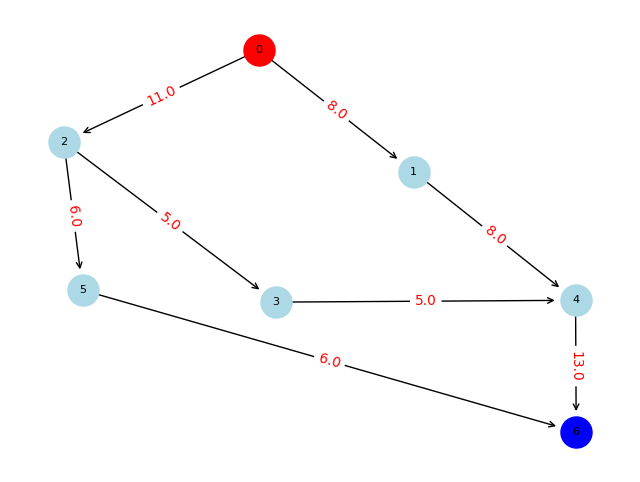

In [53]:
edges = list(G.edges())
G.remove_edges_from(edges)

for edge, val in path.items():
    v, u = map(int, edge[1:-1].split(","))
    G.add_edge(v, u, weight=val)

edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, nodelist=[s], node_color='red', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=[t], node_color='blue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, min_target_margin = 15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.axis('off')
plt.show()